# Feature Selection

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from implementations import *
from proj1_helpers import *
from misc_helpers import *
from plot_functions import *
from ml_math import *
%load_ext autoreload
%autoreload 2

In [2]:
DATA_TRAIN_PATH = 'data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
y_norm = normalize(y)
tX_norm = normalize(tX)

In [4]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_fold):
    """return the loss of ridge regression."""
    seed = 1
    k_indices = build_k_indices(y, k_fold, seed)
    
    mse_tr = 0
    mse_te = 0
    for k in range(k_fold):
        # get k'th subgroup in test, others in train:
        test_indices = k_indices[k]
        train_indices = np.delete(k_indices,k,0).flatten()
        x_tr = x[train_indices]
        y_tr = y[train_indices]
        x_te = x[test_indices]
        y_te = y[test_indices]

        # Least squares:
        w, loss = least_squares(y_tr, x_tr)

        # calculate the loss for train and test data: 
        loss_tr = compute_MSE(y_tr, x_tr, w)
        loss_te = compute_MSE(y_te, x_te, w)
    
        mse_tr += loss_tr/k_fold
        mse_te += loss_te/k_fold
        
    
    return mse_tr, mse_te

# Do some crazy feature selection here

In [5]:
#normal
cross_validation(y,tX,4)

(0.33966946818855126, 0.3398094202725914)

In [6]:
#normal normalized
cross_validation(y_norm,tX_norm,4)

(1.3586778724226265e-06, 1.3592376993433102e-06)

In [7]:
def build_poly(x, degree, linear = False):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    if linear == False:
        D = len(x[0,:])
        N = len(x[:,0])
        new_x = np.ones((N,1)) #add bias
        if degree>=1:
            for i in range(1,degree+1):
                new_x = np.append(new_x,x**i,axis=1) 
        return new_x
    else:
        m = np.zeros((len(x),degree+1))
        for j in range(degree+1):
            m[:,j] = x**j
        return m

Here is the noise level. Everything that we add should beat this error

In [12]:
#only constant feature
tX0 = build_poly(tX,0)
print(cross_validation(y,tX0,4))
#only constant feature
tX0 = build_poly(tX_norm,0)
print(cross_validation(y,tX0,4))

(0.4504921630862113, 0.4505011268124478)
(0.4504921630862113, 0.4505011268124478)


In [19]:
#linear regression
tX1 = build_poly(tX,1)
cross_validation(y,tX1,4)

(0.33942794564253254, 0.33957040705071323)

In [21]:
deg = 2
tX2 = build_poly(tX,deg)
cross_validation(y,tX2,4)

(0.3176633200431017, 0.38502220774596624)

There is overfitting

In [25]:
deg = 3
tX2 = build_poly(tX,deg)
cross_validation(y,tX2,4)

(1366.07066879478, 1390.3153219061169)

In [118]:
n,p = np.shape(tX)
loss = []
remove = []
for deg in [0,1,2,3,4,5,6,7,8,9,10]:
    for i in range(p):
        tX_ = build_poly(tX[:,i],deg, linear=True)
        loss_tr,loss_te = cross_validation(y,tX_,4)
        if loss_te > 0.45:
            remove.append((i,deg))


In [119]:
#all of these are noise
remove


[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 0),
 (21, 0),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (2, 1),
 (7, 1),
 (8, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (8, 2),
 (15, 2),
 (18, 2),
 (19, 2),
 (20, 2),
 (2, 3),
 (8, 3),
 (15, 3),
 (18, 3),
 (19, 3),
 (20, 3),
 (2, 4),
 (3, 4),
 (8, 4),
 (15, 4),
 (18, 4),
 (19, 4),
 (20, 4),
 (22, 4),
 (2, 5),
 (3, 5),
 (4, 5),
 (6, 5),
 (8, 5),
 (12, 5),
 (15, 5),
 (18, 5),
 (19, 5),
 (20, 5),
 (22, 5),
 (25, 5),
 (27, 5),
 (28, 5),
 (2, 6),
 (3, 6),
 (8, 6),
 (15, 6),
 (18, 6),
 (19, 6),
 (20, 6),
 (22, 6),
 (27, 6),
 (28, 6),
 (2, 7),
 (3, 7),
 (4, 7),
 (8, 7),
 (12, 7),
 (15, 7),
 (16, 7),
 (18, 7),
 (19, 7),
 (20, 7),
 (22, 7),
 (23, 7),
 (28, 7),
 (0, 8),
 (2, 8),
 (3, 8),
 (8, 8),
 (12, 8),
 (13, 8),
 (15, 8),
 (16,

In [120]:
all_ = []
for deg in [1,2,3,4,5,6,7,8,9,10]:
    for i in range(p):
        all_.append((i,deg))
all_

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (0, 2),
 (1, 2),
 (2, 2),
 (3, 2),
 (4, 2),
 (5, 2),
 (6, 2),
 (7, 2),
 (8, 2),
 (9, 2),
 (10, 2),
 (11, 2),
 (12, 2),
 (13, 2),
 (14, 2),
 (15, 2),
 (16, 2),
 (17, 2),
 (18, 2),
 (19, 2),
 (20, 2),
 (21, 2),
 (22, 2),
 (23, 2),
 (24, 2),
 (25, 2),
 (26, 2),
 (27, 2),
 (28, 2),
 (29, 2),
 (0, 3),
 (1, 3),
 (2, 3),
 (3, 3),
 (4, 3),
 (5, 3),
 (6, 3),
 (7, 3),
 (8, 3),
 (9, 3),
 (10, 3),
 (11, 3),
 (12, 3),
 (13, 3),
 (14, 3),
 (15, 3),
 (16, 3),
 (17, 3),
 (18, 3),
 (19, 3),
 (20, 3),
 (21, 3),
 (22, 3),
 (23, 3),
 (24, 3),
 (25, 3),
 (26, 3),
 (27, 3),
 (28, 3),
 (29, 3),
 (0, 4),
 (1, 4),
 (2, 4),
 (3, 4),
 (4, 4),
 (5, 4),
 (6, 4),
 (7, 4),
 (8, 4),
 (9, 4),
 (10, 4),
 (11, 4),
 (12, 4),
 (13, 4),


In [122]:
all_ not in remove

SyntaxError: invalid syntax (<ipython-input-122-3d7ecfb50314>, line 1)

/Users/jordanmetz/anaconda3/envs/ML_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


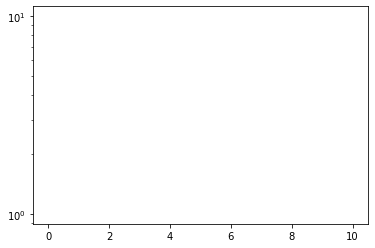

In [117]:
plt.plot(loss_tes)
plt.yscale('log')

In [97]:
remove = np.where(loss_tes > 0.45)
remove

(array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]),
 array([ 2,  7,  8, 14, 15, 16, 17, 18, 19, 20,  8, 15, 18, 19, 20,  2,  8,
        15, 18, 19, 20,  2,  3,  8, 15, 18, 19, 20, 22,  2,  3,  4,  6,  8,
        12, 15, 18, 19, 20, 22, 25, 27, 28,  2,  3,  8, 15, 18, 19, 20, 22,
        27, 28,  2,  3,  4,  8, 12, 15, 16, 18, 19, 20, 22, 23, 28,  0,  2,
         3,  8, 12, 13, 15, 16, 18, 19, 20, 22, 23, 27, 28,  0,  1,  2,  3,
         4,  6,  8, 12, 13, 15, 16, 18, 19, 20, 22, 23, 27,  0,  1,  2,  3,
         6,  8,  9, 13, 15, 16

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.24739939e-01, 3.94867978e-01, 4.50412434e-01, 4.33807223e-01,
       4.41463816e-01, 4.33934819e-01, 4.41602596e-01, 4.50436375e-01,
       4.50397368e-01, 4.39925368e-01, 4.33304245e-01, 4.17237644e-01,
       4.41502064e-01, 4.25580206e-01, 4.50501584e-01, 4.50500336e-01,
       4.50044899e-01, 4.50502501e-01, 4.50498667e-01, 4.50282050e-01,
       4.50477664e-01, 4.42230805e-01, 4.42470702e-01, 4.39316338e-01,
       4.40306289e-01, 4.40306484e-01, 4.41582311e-01, 4.41512388e-01,
       4.41513569e-01, 4.42380428e-01, 4.23764649e-01, 3.84306492e-01,
       4.48281230e-01, 4.35711904e-01, 4.26025412e-01, 4.29555937e-01,
       4.29158174e-01, 4.43776288e-01, 4.60739815e-01, 4.33393365e-01,
       4.25667802e-01, 4.14021760e-01, 4.27893134e-01, 4.16461993e-01,
       4.44731107e-01, 4.50500620e-01, 4.49788462e-01, 4.40762955e-01,
       4.50495705e-01, 4.80118589e-01, 4.50479072e-01, 4.37187911e-01,
      

In [90]:
n,p = np.shape(tX)
deg = 1
loss = []
loss_trs = []
loss_tes = []
for i in [1,5,7,9,10,11,17,21,24,25,26,27,29] :
    tX_ = build_poly(tX[:,i],deg, linear=True)
    loss_tr,loss_te = cross_validation(y,tX_,4)
    loss_trs.append(loss_tr)
    loss_tes.append(loss_te)
loss_tes = np.array(loss_tes)
loss_trs = np.array(loss_trs)

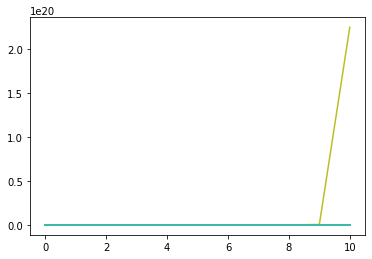

In [101]:
plt.plot(loss_tes)


In [81]:
#linear regression
tX1 = build_poly(tX,0)
cross_validation(y,tX1,4)

(0.4504921630862113, 0.4505011268124478)